## BaseLine_3
##### ● A) Train: Fine-tune an image classifier over 9 plyers_actions
##### ● B) Inference: For an image (Feature extraction for each crop and then Max-pool all the features)
##### ● C) Train: Do NN training on these features over 8 classes
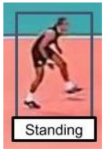

## Cloning the Repository

In [1]:
!rm -rf /kaggle/working/github
!git clone https://github.com/shehab-ashraf/Group-Activity-Recognition.git /kaggle/working/github
import sys
sys.path.append('/kaggle/working/github/')

Cloning into '/kaggle/working/github'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 113 (delta 35), reused 91 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 441.56 KiB | 15.77 MiB/s, done.
Resolving deltas: 100% (35/35), done.


## Importing Necessary Libraries

In [21]:
import torch
from functools import partial
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
import torch.nn.functional as F
import torch.optim as optim
from data_utils.dataloader import *
from data_utils.dataset import *
from Learner.learn import *
from models.BaseLine_3.model_a import *
from models.BaseLine_3.model_b import *
from helper_utils.helper import *

## Creating DataLoaders
 we create DataLoaders for train model_a to recognize players_actions

In [5]:
players_classes = ["waiting", "setting", "digging", "falling", "spiking", "blocking", "jumping", "moving", "standing"]
players_labels = {class_name:label for label, class_name in enumerate(players_classes)}


videos_path = '/kaggle/input/group-activity-recognition-volleyball/videos'
annot_path  = '/kaggle/input/group-activity-recognition-volleyball/annot_all.pkl'

train_videos = [1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54]
valid_videos = [0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51]


dls = create_dataloader(
    videos_path=videos_path,
    annot_path=annot_path,
    labels=players_labels,
    train_split=train_videos,
    valid_split=valid_videos,
    mode="player_level",
    only_middle_frame=False,
    batch_size=64,
    num_workers=4
)

## Check DataSet
see if data is prepared as we want

In [6]:
len(dls.train), len(dls.valid)

(3615, 2248)

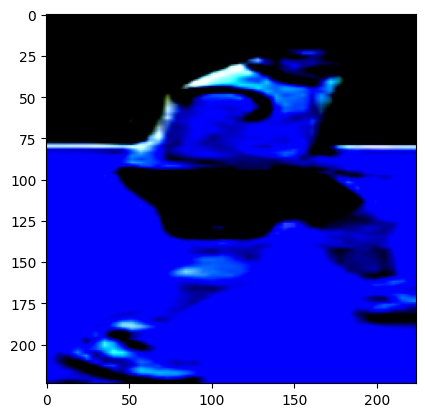

In [12]:
it = iter(dls.train)
image = next(it)[0][0]
show_image(image)

## Setting Up Training Callbacks
we define training callbacks including:<br>
MetricsCB: For tracking accuracy<br>
TrainCB: General training utilities<br>
ProgressCB: Visualizing training progress<br>
DeviceCB: Ensuring correct device allocation<br>
we then initialize the Learner class and try to find an good learning-rate.

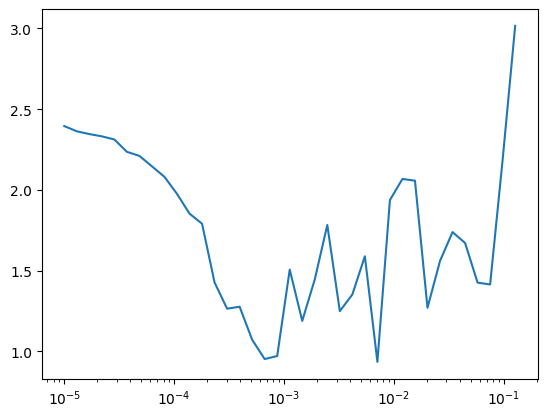

In [12]:
model = PlayerActivityClassifier(9)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs=[metrics, TrainCB(), ProgressCB(plot=True), DeviceCB()]  
learn = Learner(model, dls, loss_func=F.cross_entropy, cbs=cbs, opt_func=optim.AdamW)
learn.lr_find()

## Training Model_a
we train the model_a using the AdamW optimizer and OneCycleLR scheduler for 5 epochs.

In [13]:
lr,epochs = 6e-4,5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
model = PlayerActivityClassifier(9)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs=[metrics, TrainCB(), ProgressCB(plot=False), DeviceCB(), BatchSchedCB(sched)]  
learn = Learner(model, dls, loss_func=F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.AdamW)
learn.fit(n_epochs=epochs, lr=lr)

accuracy,loss,epoch,train
0.783,0.651,0,train
0.749,0.733,0,eval
0.803,0.573,1,train
0.776,0.702,1,eval
0.834,0.474,2,train
0.783,0.675,2,eval
0.888,0.318,3,train
0.784,0.764,3,eval
0.945,0.168,4,train
0.777,0.868,4,eval


In [ ]:
model_path = "/kaggle/working/model.pth"
torch.save(model.state_dict(), model_path) 

## Creating DataLoaders
 we create DataLoaders for train model_b to recognize group_activity

In [15]:
group_classes = ['l-pass', 'r-pass', 'l_set', 'r_set' ,'l-spike', 'r_spike', 'l_winpoint', 'r_winpoint']
group_labels = {groub_class:label for label, groub_class in enumerate(group_classes)}

videos_path = '/kaggle/input/group-activity-recognition-volleyball/videos'
annot_path  = '/kaggle/input/group-activity-recognition-volleyball/annot_all.pkl'

train_videos = [1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54]
valid_videos = [0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51]


dls = create_dataloader(
    videos_path=videos_path,
    annot_path=annot_path,
    labels=group_labels,
    train_split=train_videos,
    valid_split=valid_videos,
    mode="image_level",
    crop=True,
    only_middle_frame=False,
    batch_size=32,
    num_workers=4
)

## Check DataSet
see if data is prepared as we want

In [ ]:
len(dls.train), len(dls.valid)

In [158]:
it = iter(dls.train)
next(it)[0].shape

torch.Size([64, 12, 3, 224, 224])

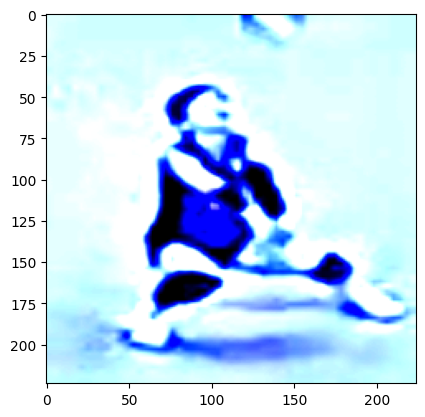

In [148]:
image = next(it)[0][0][0]
show_image(image)

## Training Model_b

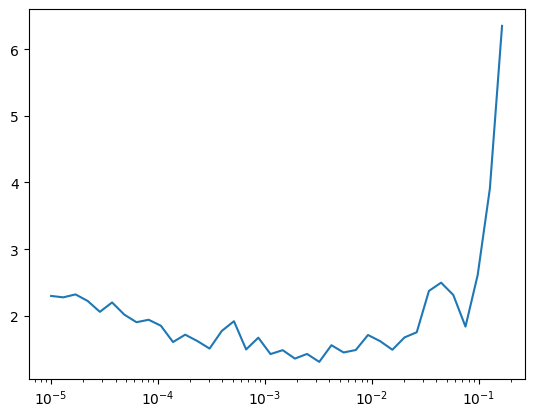

In [17]:
model.eval()
Group_Activity_Classifier = GroupActivityClassifier(model)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [metrics, TrainCB(), ProgressCB(plot=True), DeviceCB()]
Group_Activity_Learner = Learner(model=Group_Activity_Classifier, dls=dls, loss_func=F.cross_entropy, opt_func=optim.AdamW, cbs=cbs)
Group_Activity_Learner.lr_find()

In [18]:
lr,epochs = 1e-3,10
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs=[metrics, TrainCB(), ProgressCB(plot=False), DeviceCB(), BatchSchedCB(sched)]  
model.eval()
Group_Activity_Classifier = GroupActivityClassifier(model)
Group_Activity_Learner = Learner(model=Group_Activity_Classifier, dls=dls, loss_func=F.cross_entropy, opt_func=optim.AdamW, cbs=cbs)
Group_Activity_Learner.fit(n_epochs=epochs, lr=lr)

accuracy,loss,epoch,train
0.569,1.055,0,train
0.514,1.351,0,eval
0.655,0.851,1,train
0.521,1.243,1,eval
0.675,0.817,2,train
0.597,1.118,2,eval
0.703,0.745,3,train
0.621,1.080,3,eval
0.728,0.691,4,train
0.536,1.435,4,eval


## Testing
#### We are currently evaluating our model by performing a single iteration over the test_data.

In [19]:
test_videos = [4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47]
test_dataloader = create_dataloader(
    videos_path=videos_path,
    annot_path=annot_path,
    labels=group_labels,
    train_split=[],
    valid_split=test_videos,
    mode="image_level",
    only_middle_frame = False,
    batch_size=64,
    num_workers=4
)

accuracy,loss,epoch,train
0.706,0.936,0,eval


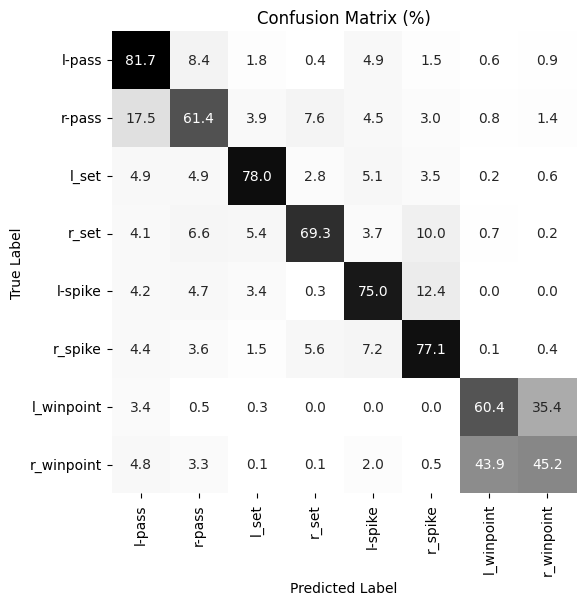

In [20]:
confusion_matrix_cb = ConfusionMatrixCB(class_names=group_classes)
cbs=[metrics, TrainCB(), ProgressCB(plot=False), DeviceCB(), confusion_matrix_cb] 
Group_Activity_Classifier.eval()
Group_Activity_Learner = Learner(model=Group_Activity_Classifier, dls=dls, loss_func=F.cross_entropy, cbs=cbs)
Group_Activity_Learner.fit(1, train=False)

## Challenges
##### Initially, training the model using only the middle frame was difficult—it resulted in overfitting and achieved just 66.2% accuracy on the test data. To address this, I modified the approach by training on 9 frames per clip instead. For Model B, I also adjusted the dataloader's batch_size to 32, enabling more optimization steps per epoch. This strategy was more effective than simply increasing the number of epochs.However, this model still struggled to predict win-points accurately. I think this is because it lost important features when focusing on player movements.